## Titanic Survival Prediction Model
This model predicts if a passenger is likely to survive the titanic tragedy.

## Work Flow
1. Data Exploration (EDA)
2. Feature Selection
2. Pipeline Creation (transformer, preprocessor, model training and tuning)
3. Model Evaluation
4. Run Predictions on Test data
5. Submit Results

`We dont need feature importance here to reduce the data because we have very few features`

### 1. Data Exploration

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# Remove warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Import the data
train_df = pd.read_csv('data/train.csv')
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# See statistics on the data
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


We can see the max age is 80 but the mean is 29, which means we have more younger passengers.

In [5]:
# check for nulls
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Age, Cabin and Embarked have null values

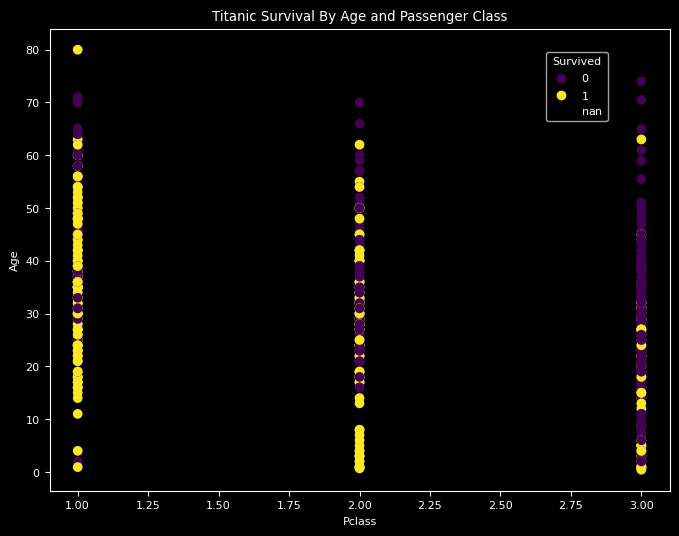

In [6]:
# Visualize survived by age group and passenger class

plt.style.use("dark_background")

# Set global font size
plt.rcParams.update({'font.size': 8}) 

# Create Figure and Axes instance
fig, ax = plt.subplots(figsize=(8, 6))

# Plot data directly to the Axes instance
scatter = ax.scatter(train_df["Pclass"], 
                     train_df["Age"], 
                     c=train_df["Survived"]) # Colour the data with the "target" column

# Customize the plot parameters 
ax.set(title="Titanic Survival By Age and Passenger Class",
       xlabel="Pclass",
       ylabel="Age");

# Setup the legend
ax.legend(*scatter.legend_elements(), title="Survived", loc=(0.8,0.8), fontsize=8, title_fontsize=8);

We can see from the diagram above that 3rd class passengers above 30yrs of age recorded the highest deaths

In [7]:
# Check data types and table info
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


We can see Age and Cabin have null values

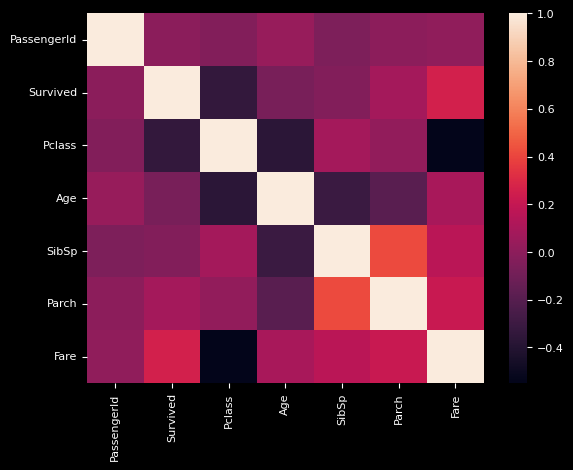

In [8]:
# See correlation between features and label
import seaborn as sns
sns.heatmap(train_df.select_dtypes(include='number').corr());

### 2. Feature Selection

We can see all features in the chart except passengerid have a positive or negative correlation to survived. Fare and Pclass could be used interchangeably, since the fare is directly tied to the passenger class .
We would not use the following features;
* `Passenger Id - high-cardinality (too many distinct values)`
* `Name - high-cardinality (too many distinct values)`
* `Ticket - high-cardinality (too many distinct values)`

We would use the following features
* `numeric_features = Pclass, Age, SibSp, Parch, Fare`
* `categorical_features = Sex, Cabin, Embarked`

In a bigger project we could use a list comprehension to filter our features with high cardinality and then reduce features with no or very little correlation to the target.

### 3. Pipeline Creation (feature selection, transformer, preprocessor, model training and tuning)

In [9]:
# Import packages
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle


# Split the data into features and label
X = train_df.drop('Survived', axis = 1)
y = train_df['Survived']

# Feature selection: select numeric and categorical features needed
numeric_features = ['Pclass','Age','SibSp','Parch','Fare']
categorical_features = ['Sex','Cabin','Embarked']

# Create numeric transformer
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Create categorical transformer
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('one_hot', OneHotEncoder(handle_unknown='ignore'))
])

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers = [
        ('numeric', numeric_transformer, numeric_features),
        ('categorical', categorical_transformer, categorical_features)
    ]
)

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Define the parameter grid
param_grid = {
    'classifier__n_estimators': np.arange(10, 500, 20),
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': np.arange(2, 10, 2),
    'classifier__min_samples_leaf': np.arange(1, 10, 2)
}

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

# Run a grid search cross validation to get the best model
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Fit the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)
print("Best score on test data: ", grid_search.best_estimator_.score(X_test, y_test))

# Save the model
pickle.dump(grid_search.best_estimator_, open("model/titanic-prediction.pkl", "wb"))

Best parameters found:  {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 110}
Best cross-validation score:  0.8328572835615089
Best score on test data:  0.8100558659217877


### 3. Model Evaluation

 Model was evaluated in the previous cell, but we would run more evaluations.

In [10]:
# Import evaluation metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Maintain same result
np.random.seed(42)

# Load the model
model = pickle.load(open("model/titanic-prediction.pkl", "rb"))

# Run predictions
y_preds = model.predict(X_test)

print("Accuracy Score: ", accuracy_score(y_test, y_preds))
print("Confusion Matrix : ", confusion_matrix(y_test, y_preds))
print("Classification Report", classification_report(y_test, y_preds))

Accuracy Score:  0.8100558659217877
Confusion Matrix :  [[95 10]
 [24 50]]
Classification Report               precision    recall  f1-score   support

           0       0.80      0.90      0.85       105
           1       0.83      0.68      0.75        74

    accuracy                           0.81       179
   macro avg       0.82      0.79      0.80       179
weighted avg       0.81      0.81      0.81       179



### 4. Run Prediction on Test data

In [11]:
test_df = pd.read_csv("data/test.csv")
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [12]:
# Run prediction on test data
predictions = model.predict(test_df)
predictions[:10]

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0], dtype=int64)

In [13]:
test_df['Survived'] = predictions
submission = test_df[['PassengerId','Survived']]
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [14]:
# check data length is same with required length
len(submission)

418

### 5. Submit Results

In [15]:
# submit results
submission.to_csv('submission/submission.csv', index=False)